In [0]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython import display
import numpy as np


In [0]:
batch_size = 128
epochs = 100
torch.manual_seed(1)
learning_rate = 1e-3

In [0]:
input_dim= 28*28
hidden_dim=400
code_dim=20

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)       # 784 , 400
        self.fc21 = nn.Linear(hidden_dim, code_dim)       # 400 , 20
        self.fc22 = nn.Linear(hidden_dim, code_dim)       # 400 , 20

        #decoder
        self.fc3 = nn.Linear(code_dim, hidden_dim)        #  20 , 400
        self.fc4 = nn.Linear(hidden_dim, input_dim)       # 400 , 784

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def loss_function(recon_x, x, mu, logvar):

  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD

In [0]:
def train():
  model.train()
  train_loss = 0
  for i, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  
  return train_loss


In [0]:
def test():
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      test_loss += loss_function(recon_batch, data, mu, logvar).item()

  return test_loss

Before Trainig


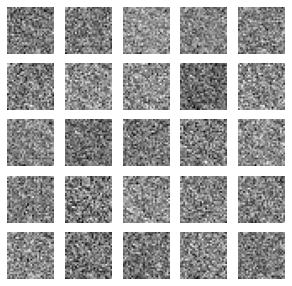

In [0]:
with torch.no_grad():
  print('Before Trainig')
  sample = torch.randn(64, 20).to(device)
  sample = model.decode(sample).cpu()
  fig = plt.figure(figsize=(5,5))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample[i].reshape(28,28),cmap='gray')
    plt.axis('off')
      
plt.show()

Epoch :  2 / 100


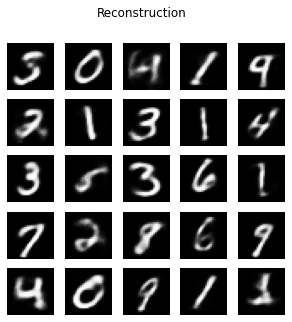

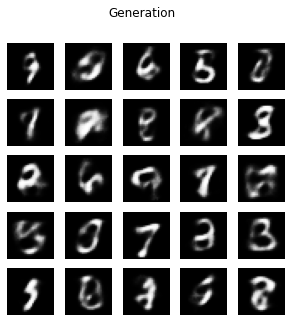

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

In [0]:
tar=[]
ter=[]

for e in range(epochs):
  tr=train()/len(train_loader.dataset)
  te=test()/len(test_loader.dataset)
  tar.append(tr)
  ter.append(te)
  display.clear_output(wait=True)
  print('Epoch : ',e+1,'/',epochs)

  with torch.no_grad():
    
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Reconstruction')
    for i in range(25):
      sample = model(train_loader.dataset[i][0].to(device))[0].cpu()
      plt.subplot(5,5, i+1)
      plt.imshow(sample.reshape(28,28),cmap='gray')
      plt.axis('off')

  plt.show()

  with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Generation')
    for i in range(25):
      plt.subplot(5,5, i+1)
      plt.imshow(sample[i].reshape(28,28),cmap='gray')
      plt.axis('off')

  plt.show()




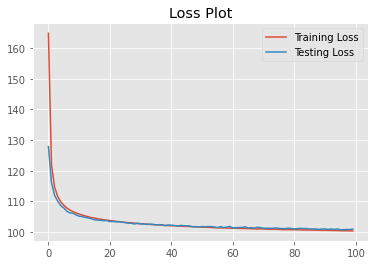

In [0]:
plt.style.use('ggplot')
plt.title('Loss Plot')
plt.plot(tar,label='Training Loss')
plt.plot(ter,label='Testing Loss')
plt.legend()
plt.show()

In [0]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
N=700
lat=[]
labels=[]
for i in range(N):
  dat=train_loader.dataset[i][0]
  label=train_loader.dataset[i][1]
  ou=model.encode(dat.reshape(1,784).to(device))
  latent=model.reparameterize(ou[0],ou[1])
  lat.append(latent.cpu().detach().numpy())
  labels.append(label)


In [0]:
lat=np.array(lat)
lat=lat.reshape(N,20)

In [0]:
lat2 = TSNE(n_components=2).fit_transform(lat)

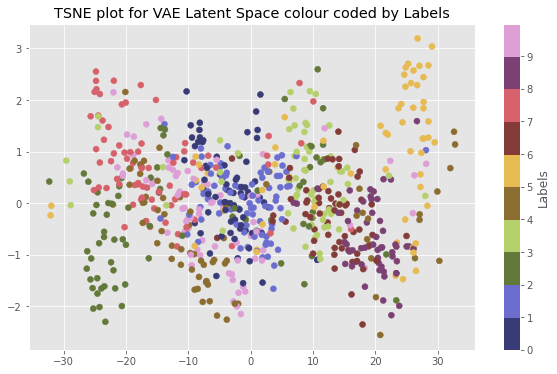

In [0]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(10,6))
cmap = plt.cm.tab20b
cmaplist = [cmap(i) for i in range(cmap.N)]
bounds = np.linspace(0,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(lat2[:,0],lat[:,1],c=labels,cmap=cmap,norm=norm)
cb = plt.colorbar(scat,ticks=[i for i in range(10)])
cb.set_label('Labels')
ax.set_title('TSNE plot for VAE Latent Space colour coded by Labels')
plt.show()

In [0]:
trainx=[]
trainy=[]
testx=[]
testy=[]
model.eval()
for i in range(len(train_loader.dataset)):
  dat = train_loader.dataset[i][0]
  ou=model.encode(dat.reshape(1,784).to(device))
  latent=model.reparameterize(ou[0],ou[1])
  trainx.append(latent.cpu().detach().numpy().reshape(20))
  trainy.append(train_loader.dataset[i][1])

for i in range(len(test_loader.dataset)):
  dat = test_loader.dataset[i][0]
  ou=model.encode(dat.reshape(1,784).to(device))
  latent=model.reparameterize(ou[0],ou[1])
  testx.append(latent.cpu().detach().numpy().reshape(20))
  testy.append(test_loader.dataset[i][1])

In [0]:
! pip install -q scikit-plot

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import scikitplot as skplt

In [0]:
clf=SVC()
clf.fit(trainx,trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
predy=clf.predict(testx)
clf.score(testx,testy)

0.9739

In [0]:
print(classification_report(testy,predy))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



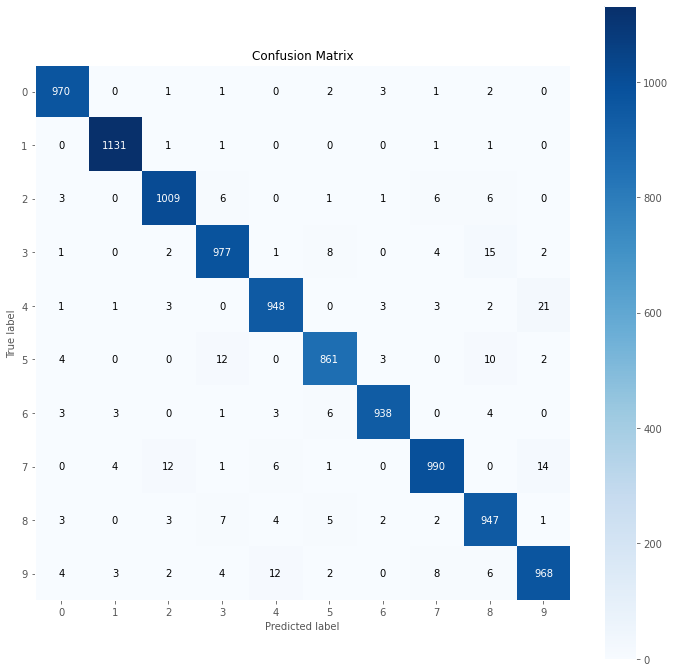

In [0]:
skplt.metrics.plot_confusion_matrix(testy, predy,figsize=(12,12))

In [0]:
torch.save(model.state_dict(), 'model_weights.pt')